In [1]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import collections
from scipy.stats.mstats import zscore

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [312]:
#ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImages.pkl"
ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImagesBottomUp.pkl"
urlPrepend = "https://nms.kcl.ac.uk/netsys/data/urbanBeautyCrowd/"
#ImageList = "/datasets_1/sagarj/BellLabs/Data/mediumImages.pkl"
with open(ImageList , 'rb') as f:
    imgList = pickle.load(f)

In [3]:
len(imgList)

1000

In [4]:
AMImages = "/datasets/sagarj/streetView/Transform_1000/"
#AMImages = "/datasets/sagarj/streetView/Transform_Medium/"

In [5]:
files = os.listdir(AMImages)

In [6]:
files[1].split('_')

['513d7e35fdc9f03587007365', '0001', '0.414554', '.jpg']

In [7]:
filesMap = {}
for f in files:
    comps = f.strip().split('_')
    filesMap[comps[0]] = {}
    filesMap[comps[0]]['path'] = AMImages + f
    filesMap[comps[0]]['act'] = comps[2]
    filesMap[comps[0]]['changeLabel'] = comps[1][-1]

In [8]:
len(filesMap.keys())

1000

In [9]:
for row in imgList:
    if row[1]['key'] in filesMap.keys():
        filesMap[row[1]['key']]['origPath'] = row[1]['path']
        filesMap[row[1]['key']]['label'] = row[1]['label']

In [10]:
filesMap[filesMap.keys()[1]]

{'act': '0.462293',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg',
 'path': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg'}

In [11]:
#Image(filesMap['513d9f45fdc9f035870086b4']['origPath'])

In [12]:
#Image(filesMap['513d9f45fdc9f035870086b4']['path'])

In [13]:
#filesMap['513d9f45fdc9f035870086b4']['changeLabel']

In [14]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(DataDict):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    for k in DataDict:
        path = DataDict[k]['path'].strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,4096))
        else:
            im = transformer.preprocess('data',caffe.io.load_image(path))
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['fc7'].data.copy()
                
        DataDict[k]['placesFeats'] = featArray
    return DataDict

def getPlaces(path):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    path = path.strip()
    if not os.path.exists(path):
        featArray = np.zeros((1,4096))
    else:
        im = transformer.preprocess('data',caffe.io.load_image(path))
        net.blobs['data'].data[...] = im - meanMat
        net.forward()
        featArray = net.blobs['prob'].data.copy()
    return featArray

In [15]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

In [16]:
transformedFilesMap = getFeatMatrix(filesMap)

In [17]:
transformedFilesMap[transformedFilesMap.keys()[151]]

{'act': '1.21166',
 'changeLabel': '0',
 'label': 1,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f448a4fdc9f065f00040ba.jpg',
 'path': '/datasets/sagarj/streetView/Transform_1000/50f448a4fdc9f065f00040ba_0000_1.21166_.jpg',
 'placesFeats': array([[ 0.        ,  0.72337198,  0.        , ...,  0.20558679,
          0.14917183,  0.        ]], dtype=float32)}

# This is an extremely shitty part of the code. The crux is you need the test data in a key : dict{} format where the dict should have a 'origPath' entry with the path of the test image which we are retrevi

In [18]:
# with open("../Data/TrainImageListBinary_augmented.txt",'r') as f:
#     imagePaths = f.readlines()

In [19]:
#len(imagePaths)

In [20]:
#sampledpaths[1]

In [21]:
# sampledpaths = random.sample(imagePaths , 5000)

In [22]:
# with open("../Data/sampledSegnetImages.pkl",'wb') as f:
#     pickle.dump(sampledpaths,f,protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('../Data/testSegnetFeatures.pkl', 'rb') as handle:
    testSegnetLabels = pickle.load(handle)
#with open('../Data/retrievalSegnetLabelsTextures.pkl', 'rb') as handle:
#    segnetLabels = pickle.load(handle)

with open('../Data/fringe1000SegnetFeatures.pkl', 'rb') as handle:
    segnetLabels = pickle.load(handle)


In [24]:
with open('../Data/testImages.pkl', 'rb') as handle:
    testImages = pickle.load(handle)

In [25]:
testKeys = [i[1]['key']  for i in testImages]
transformedKeys = [k for k in filesMap]

In [26]:
common = [k for k in transformedKeys if k in testKeys]

In [27]:
len(common)

479

In [28]:
testImages[1]

('513d7ffefdc9f0358700767c',
 {'key': '513d7ffefdc9f0358700767c',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7ffefdc9f0358700767c.jpg',
  'trueSkill': [30.94110828649425]})

In [29]:
filteredTestImages = []
for k in testImages:
    if k[0] not in common:
        filteredTestImages.append(k)

In [30]:
filteredTestImages[0]

('50f447d2fdc9f065f0003a7d',
 {'key': '50f447d2fdc9f065f0003a7d',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f447d2fdc9f065f0003a7d.jpg',
  'trueSkill': [30.93538936269406]})

In [31]:
dataFileMap = {}
for p in filteredTestImages:
    path = p[1]['path']
    key = p[1]['key']
    dataFileMap[key] = {}
    dataFileMap[key]['path'] = path

In [32]:
dataFileMap[dataFileMap.keys()[1]]

{'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513e6297fdc9f0358700b6fd.jpg'}

In [33]:
retreivalFileMap = getFeatMatrix(dataFileMap)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# End shitty zone now. the next sections are about matching

In [34]:
from scipy.spatial import distance
distanceMapper = {}
for k in filesMap:
    distanceMapper[k] = {}
    for i in retreivalFileMap:
        #distanceMapper[k][i] = angle_between(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        distanceMapper[k][i] = distance.euclidean(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])

In [35]:
len(distanceMapper.keys())

1000

In [36]:
#distanceMapper[distanceMapper.keys()[0]]

In [37]:
import operator
top5s = {}
for k in distanceMapper:
    top5s[k]=sorted(distanceMapper[k].items(), key=operator.itemgetter(1))[:5]
    

In [38]:
top5s[top5s.keys()[1]]

[('50f60c41beb2fed910000174', 21.436391830444336),
 ('513d7cb7fdc9f03587006faa', 21.553407669067383),
 ('50f561bcfdc9f065f0005640', 21.70827865600586),
 ('50f55eaffdc9f065f0004dfa', 22.45761489868164),
 ('50f5eeb0fdc9f065f0009006', 22.798471450805664)]

In [39]:
# index = pd.Series(range(len(filesMap.keys())))
# column = ['key' , 'origPath' ,'XformPath' , 'Top5Keys' , 'Top5Paths']

In [40]:
filesMap[filesMap.keys()[1]]

{'act': '0.462293',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg',
 'path': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'placesFeats': array([[ 0.22105652,  0.61728495,  0.        , ...,  1.17217755,
          0.31463331,  0.        ]], dtype=float32)}

In [41]:
retreivedDf = {}

In [42]:
for k in filesMap:
    top5Keys = [p[0] for p in top5s[k]]
    top5Paths = [dataFileMap[p[0]]['path'] for p in top5s[k]]
    origPath = filesMap[k]['origPath']
    xformPath = filesMap[k]['path']
    retreivedDf[k] = dict()
    retreivedDf[k] = {'key' : k , 'origPath' : origPath ,'XformPath' : xformPath , 'Top5Keys' : [top5Keys] , 'Top5Paths' : [top5Paths]}

In [43]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['50f60c41beb2fed910000174',
   '513d7cb7fdc9f03587006faa',
   '50f561bcfdc9f065f0005640',
   '50f55eaffdc9f065f0004dfa',
   '50f5eeb0fdc9f065f0009006']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/50f60c41beb2fed910000174.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7cb7fdc9f03587006faa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f561bcfdc9f065f0005640.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f55eaffdc9f065f0004dfa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eeb0fdc9f065f0009006.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'key': '5140ca1cfdc9f0492600272f',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg'}

In [44]:
retreivedDf[retreivedDf.keys()[10]]['Top5Paths'][0]

['/work/sagarj/Work/BellLabs/streetview/PPImages/513d5fd9fdc9f03587003c47.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5e566fdc9f065f000683b.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eba2fdc9f065f000839e.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eb1ffdc9f065f0007ff3.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/514134dafdc9f049260047ea.jpg']

In [45]:
# for k in range(len(retreivedDf.keys()[:90])):
#     print retreivedDf[retreivedDf.keys()[k]]['XformPath']

In [557]:
k =  51 #56 #54 #196 #193 #31 #30 #111 #24 #111 #16 #190 16 #15 #114 #54 #40 

In [558]:
retreivedDf[retreivedDf.keys()[k]]['XformPath']

'/datasets/sagarj/streetView/Transform_1000/513cdab0fdc9f0358700201e_0001_0.460806_.jpg'

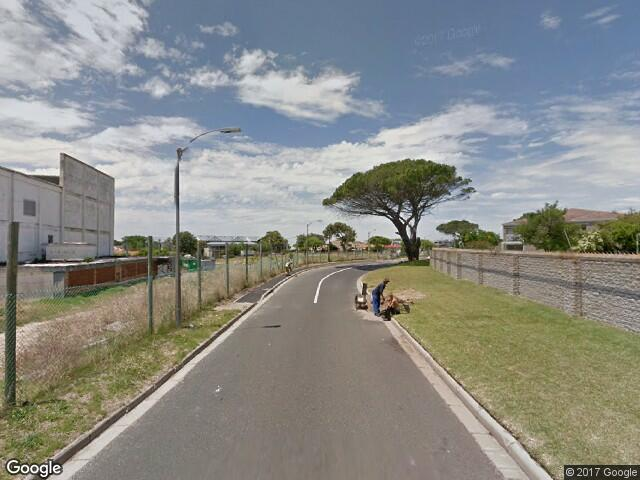

In [559]:
Image(retreivedDf[retreivedDf.keys()[k]]['origPath'])

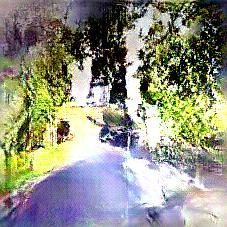

In [560]:
Image(retreivedDf[retreivedDf.keys()[k]]['XformPath'])

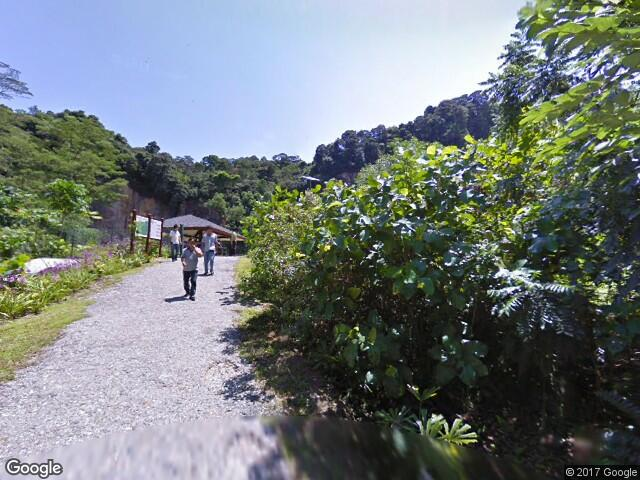

In [564]:
Image(retreivedDf[retreivedDf.keys()[k]]['Top5Paths'][0] [3])

In [454]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['50f60c41beb2fed910000174',
   '513d7cb7fdc9f03587006faa',
   '50f561bcfdc9f065f0005640',
   '50f55eaffdc9f065f0004dfa',
   '50f5eeb0fdc9f065f0009006']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/50f60c41beb2fed910000174.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7cb7fdc9f03587006faa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f561bcfdc9f065f0005640.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f55eaffdc9f065f0004dfa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eeb0fdc9f065f0009006.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'key': '5140ca1cfdc9f0492600272f',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg'}

In [328]:
from shutil import copyfile
import csv

In [331]:
#Sample images for mturk experiment

# mturkDir = "/work/sagarj/Work/work_ipython/BellLabs/Data/Mturk/"
# urlPrepend = "https://nms.kcl.ac.uk/netsys/data/urbanBeautyCrowd/Mturk/"
# original = "Grp1/"
# Xformed = "Grp2/"
# batchSize = 200
# start = 0
# saveDict = {}
# turk = open(mturkDir + "csvMturk.csv" , 'wb')
# csvWriter = csv.writer(turk, delimiter=',')
# csvWriter.writerow(['image_A_url' ,'image_B_url'])
# for k in retreivedDf:
#     label = retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1]
#     saveDict[k] = label
#     srcFile = k+'_o.jpg'
#     destFile = k+'_x.jpg'
#     copyfile(retreivedDf[k]['origPath'] , mturkDir + original + srcFile)
#     copyfile(retreivedDf[k]['Top5Paths'][0][0] , mturkDir + Xformed + destFile)
#     csvWriter.writerow([urlPrepend + original + srcFile , urlPrepend + Xformed + destFile])
#     start+=1
#     if start >= batchSize:
#         break
# turk.close()

# with open("../Data/mturkPilotLabels.pkl",'wb') as f:
#     pickle.dump(saveDict , f , protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
    



In [375]:
with open("../Data/mturkPilotLabels.pkl",'rb') as f:
    saveDict = pickle.load(f)

In [52]:
# with open("../Data/retreivedfringeDataframe2.pkl" , 'wb') as f:
#     pickle.dump(retreivedDf , f , protocol=pickle.HIGHEST_PROTOCOL)

In [381]:
mturkResults = "../Data/mturk_pilot2.csv"
results = pd.read_csv(mturkResults)


In [382]:
grouped = results.groupby('HITId')
votes = {}
for k in grouped.groups.keys():
    votes[k] = grouped.get_group(k)

In [383]:
#results.head()

In [397]:
beautyAgree = 0
beautyDisagree = 0
uglyAgree = 0
uglyDisagree = 0
totalb = 0
totalu = 0
#confuse = 0
for k in votes:
    a  = sum(votes[k]['Answer.choice'] == 'optionB')
    key = votes[k]['Input.image_A_url'].iloc[0].split('/')[-1].split('_')[0]
    if key in saveDict:
        if saveDict[key]=='1':
            totalb+=1
            if a >= 2: 
                beautyAgree+=1
            else:
                beautyDisagree+=1
        else:
            totalu+=1
            if a < 2:
                uglyAgree+=1
            else:
                uglyDisagree+=1
                
            
        

In [398]:
print float((beautyAgree + uglyAgree))/200 , float(beautyAgree)/totalb , float(uglyAgree)/totalu

0.765 0.690909090909 0.855555555556


# After this step, run the segnet code to extract the right labeled pixel info

In [53]:
len(segnetLabels.keys()) , len(testSegnetLabels.keys())

(1000, 5000)

In [54]:
collections.Counter(np.squeeze(testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels']).flatten())

Counter({0.0: 53775,
         1.0: 28146,
         2.0: 141,
         3.0: 11,
         4.0: 36008,
         5.0: 27439,
         6.0: 12616,
         7.0: 710,
         8.0: 11057,
         9.0: 2309,
         10.0: 360,
         11.0: 228})

In [55]:
segnetLabels[segnetLabels.keys()[10]]['segnetLabels'].shape

(360, 480)

In [56]:
testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels'].shape

(360, 480)

In [57]:
retreivedDf[retreivedDf.keys()[101]]['Top5Keys'][0]

['514137dafdc9f0492600509c',
 '513d5749fdc9f0358700313d',
 '50f5e566fdc9f065f000683b',
 '50f447ccfdc9f065f00039e4',
 '5140c9d8fdc9f04926002668']

# This section is for calculating normalized ratios of the segnet labels

In [58]:
def normalizeDict(d, denom):
    normDict = {}
    for k in d : 
        normDict[k] = float(d[k])/float(denom)
    return normDict

deltas = {}
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    deltas[retreivedDf[k]['key']] = {}
    deltas[retreivedDf[k]['key']]['act'] = xformact
    deltas[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'])
    denom = labels.shape[0]*labels.shape[1]
    if retreivedDf[k]['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'].flatten())) , denom)
        deltas[retreivedDf[k]['key']]['origLabels'] = {}
        deltas[retreivedDf[k]['key']]['origLabels'] = origLabels
        deltas[retreivedDf[k]['key']]['top5'] = []
        matchList = retreivedDf[k]['Top5Keys'][0]
        for l in matchList:  
            if l in testSegnetLabels.keys():
                deltas[retreivedDf[k]['key']]['top5'].append(normalizeDict(collections.Counter(np.squeeze(testSegnetLabels[l]['segnetLabels'].flatten())) , denom))
                
    
    
    
    
    

In [59]:
deltas[deltas.keys()[1]]

{'act': 0.462293,
 'label': 1,
 'origLabels': {0.0: 0.33640046296296294,
  1.0: 0.12648148148148147,
  2.0: 0.03882523148148148,
  3.0: 0.001267361111111111,
  4.0: 0.19147569444444446,
  5.0: 0.0064756944444444445,
  6.0: 0.1947337962962963,
  7.0: 0.0039641203703703705,
  8.0: 0.01369212962962963,
  9.0: 0.08643518518518518,
  10.0: 0.0002488425925925926},
 'top5': [{0.0: 0.11725694444444444,
   1.0: 0.029207175925925925,
   2.0: 0.00047453703703703704,
   3.0: 4.050925925925926e-05,
   4.0: 0.2298784722222222,
   5.0: 0.05997106481481482,
   6.0: 0.5504224537037037,
   7.0: 0.0022569444444444442,
   8.0: 0.009756944444444445,
   9.0: 0.00022569444444444443,
   11.0: 0.0005092592592592592},
  {0.0: 0.3008564814814815,
   1.0: 0.06425925925925927,
   2.0: 0.002991898148148148,
   3.0: 0.0008333333333333334,
   4.0: 0.20097800925925927,
   5.0: 0.17759837962962963,
   6.0: 0.20689814814814814,
   7.0: 3.472222222222222e-05,
   8.0: 0.045167824074074076,
   9.0: 0.00038194444444444446},

In [200]:
# with open("SegnetDictionary.pkl" , 'wb') as f:
#     pickle.dump(deltas , f , protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [61]:
# deltas[deltas.keys()[100]]['top5']
mean = {}
std = {}

scores = {}
beautfiedScores = {}
uglifiedScores = {}
origScores = {}
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            if dim not in scores:
                
                origScores[dim] = []
                beautfiedScores[dim] = []
                uglifiedScores[dim] = []
                scores[dim] = []
            scores[dim].append(ratios[dim])
            
            #Find change in scores and the score 
            orig_score = 0.0
            if dim in deltas[k]['origLabels']:
                orig_score = deltas[k]['origLabels'][dim]
            origScores[dim].append(orig_score)
            if deltas[k]['label'] == 1:
                beautfiedScores[dim].append(ratios[dim] - orig_score)
            else:
                uglifiedScores[dim].append(ratios[dim] - orig_score)
#print scores.keys()
for k in origScores:
    mean[k] = np.mean(origScores[k])
    std[k] = np.std(origScores[k])
    
print mean , std

{0.0: 0.21943551490900831, 1.0: 0.15964103587962963, 2.0: 0.010513424022829728, 3.0: 0.0064589505444566783, 4.0: 0.20238563066647375, 5.0: 0.077390642361111123, 6.0: 0.24092232638888886, 7.0: 0.0014544147887388375, 8.0: 0.028656118169947772, 9.0: 0.04860750542250844, 10.0: 0.003835504966405561, 11.0: 0.0016830555779371345} {0.0: 0.14233801836072049, 1.0: 0.1779756827513482, 2.0: 0.010277734267026403, 3.0: 0.0094944698156632298, 4.0: 0.099809126386826263, 5.0: 0.065296453686668421, 6.0: 0.19999049458111548, 7.0: 0.0030817056165186466, 8.0: 0.032784515056578492, 9.0: 0.059597755355897009, 10.0: 0.010165226711118103, 11.0: 0.0051485082009738682}


In [62]:
#calculate change in object value in terms of Zscore in original population


beautfiedZscores = {}
uglifiedZscores = {}
for k in beautfiedScores:
    if k not in beautfiedZscores:
        beautfiedZscores[k] = []
        
    for val in beautfiedScores[k]:
        orig = beautfiedScores[dim]
        Zscore = (orig - mean[dim])/std[dim]
        beautfiedZscores[k].append(Zscore)


for k in uglifiedScores:
    if k not in uglifiedZscores:
        uglifiedZscores[k] = []
        
    for val in uglifiedScores[k]:
        orig = uglifiedScores[dim]
        Zscore = (orig - mean[dim])/std[dim]
        uglifiedZscores[k].append(Zscore)

In [63]:
#beautfiedScores[1]

In [64]:
dim = 6

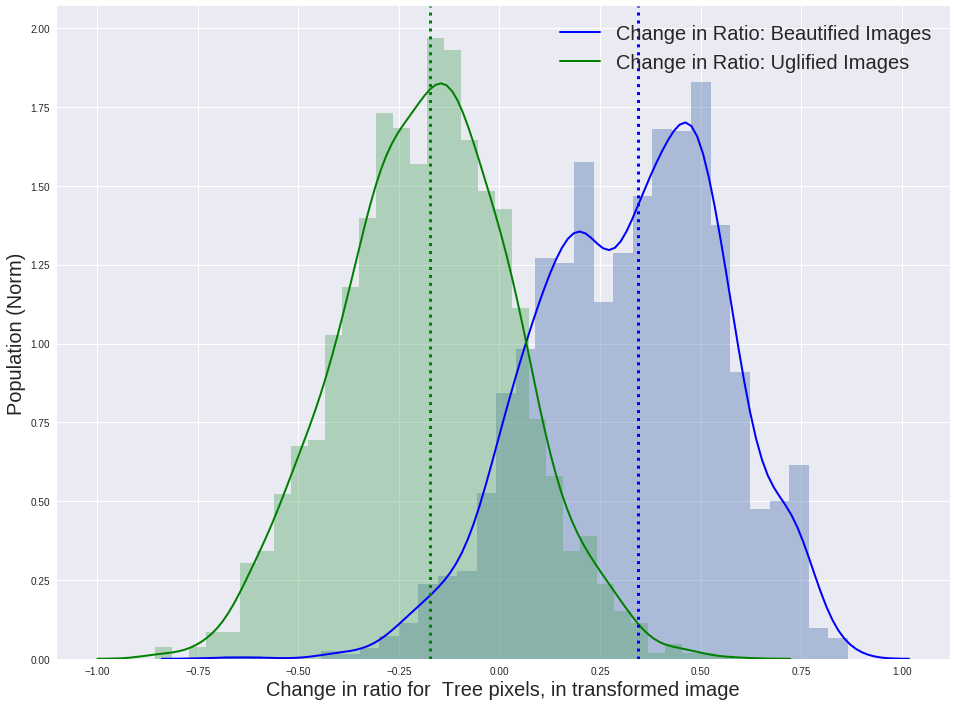

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautfiedScores[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Change in Ratio: Beautified Images"})
sns.distplot(uglifiedScores[dim] , kde_kws={"color": "g", "lw": 2, "label": "Change in Ratio: Uglified Images"})
ax.axvline(x=np.median(beautfiedScores[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglifiedScores[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Change in ratio for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [203]:
labels = []
vectors = []
dims = [0.0 , 1.0 ]
sky = []
for k in deltas:
    for ratios in deltas[k]['top5']:
        vec = []
        for j in dims:
            compound = 1.0
            if j in ratios:
                if j in deltas[k]['origLabels']:
                    vec.append(ratios[j]-deltas[k]['origLabels'][j])
                else:
                    vec.append(ratios[j])
                
            else:
                vec.append(0.0)
        for val in vec:
            compound = compound * val
        vec.append(compound)
        if 0.0 in ratios:
            if 0.0 in deltas[k]['origLabels']:
                sky.append(ratios[0.0]-deltas[k]['origLabels'][0.0])
            else:
                sky.append(ratios[0.0])
            #sky.append(ratios[0.0]/ratios[6.0])
        else:
            sky.append(0.0)
        labels.append(deltas[k]['label'])
        vectors.append(vec)
        

In [204]:
#deltas[deltas.keys()[1]]

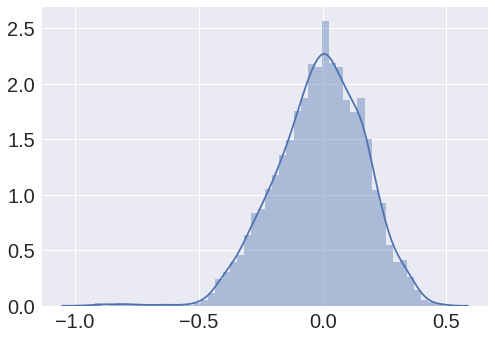

In [205]:

sns.distplot(sky)

In [208]:
bins = {}
for i in range(5):
    bins[i] = {}
    bins[i]['label'] = []
    bins[i]['beauty'] = []
    bins[i]['ugly'] = []

#this bit is for finding sky trends in an absolute sense.

# for k in range(len(sky)):
#     if sky[k] <= 0.07 :
#         bins[0]['label'].append(labels[k])
#     elif sky[k] > 0.07 and sky[k] <= 0.14:
#         bins[1]['label'].append(labels[k])
#     elif sky[k] >0.14 and sky[k] <= 0.21:
#         bins[2]['label'].append(labels[k])
#     elif sky[k] >  0.21 and sky[k] <= 0.28:
#         bins[3]['label'].append(labels[k])
#     elif sky[k] > 0.28 and sky[k] <= 0.35 :
#         bins[4]['label'].append(labels[k])
#     elif sky[k] > 0.35 :
#         bins[5]['label'].append(labels[k])

#This bit is to find binned plot for Sky Delta

for k in range(len(sky)):
    if sky[k] <= -0.3 :
        bins[0]['label'].append(labels[k])
    elif sky[k] > -0.3 and sky[k] <= -0.1:
        bins[1]['label'].append(labels[k])
    elif sky[k] >-0.1 and sky[k] <= 0.1:
        bins[2]['label'].append(labels[k])
    elif sky[k] > 0.1 and sky[k] <= 0.3:
        bins[3]['label'].append(labels[k])
#     elif sky[k] > 0.3 and sky[k] <= 0.5 :
#         bins[4]['label'].append(labels[k])
    elif sky[k] > 0.3 :
        bins[4]['label'].append(labels[k])
    
iters = 100 
sampleSize = 50
for i in range(iters):
    for k in bins:
        sample = random.sample(bins[k]['label'] , sampleSize)
        bins[k]['beauty'].append(sum(sample))
        bins[k]['ugly'].append(len(sample) - sum(sample))

(array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.]),
 <a list of 10 Text yticklabel objects>)

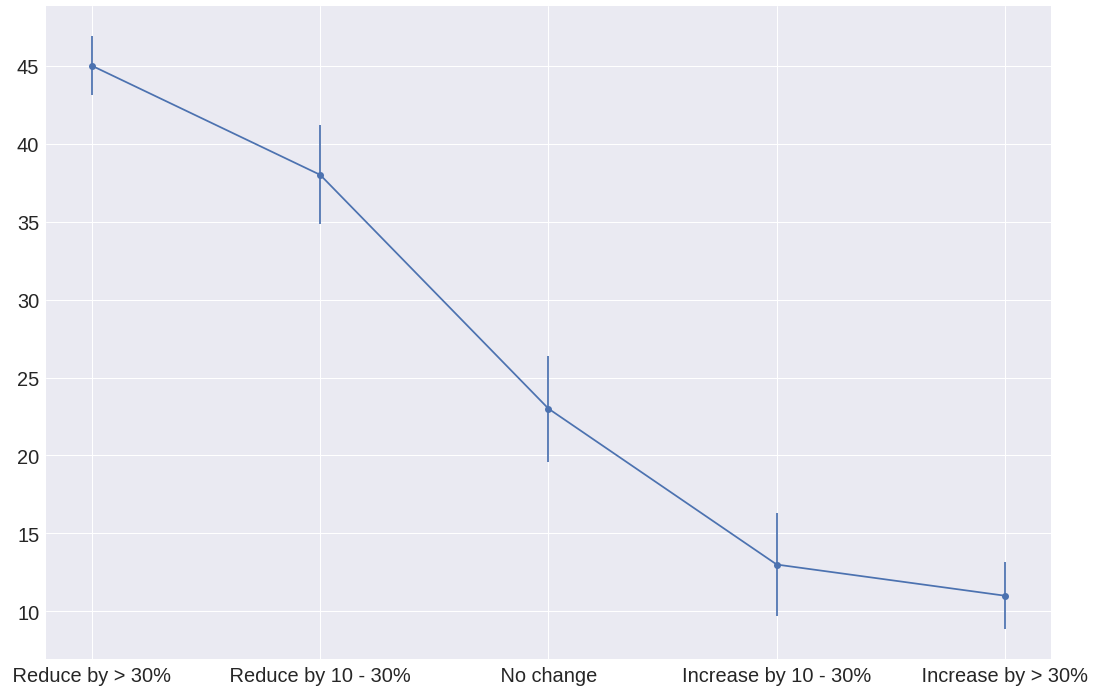

In [568]:
fig, ax = plt.subplots()
fig.set_size_inches(18,12)
errorBeauty = [np.std(bins[i]['beauty']) for i in bins]
ax.errorbar(np.arange(0,len(bins), 1), [np.median(bins[i]['beauty']) for i in bins], yerr=errorBeauty, fmt='-o')
# plt.plot([np.median(bins[i]['ugly']) for i in bins])
#errorUgly = [np.std(bins[i]['ugly']) for i in bins]
#ax.errorbar(np.arange(0,len(bins), 1), [np.median(bins[i]['ugly']) for i in bins], yerr=errorUgly, fmt='-o')
#plt.xlabel(" Changes in Sky pixels " , fontsize = 20)
#plt.ylabel("Percentage of images belonging to a bin" , fontsize = 20 )

#ticks = [' Less Sky ' , ' ' , '' , '', ' More Sky ' ]
ticks = [' Reduce by > 30% ' , ' Reduce by 10 - 30% ' , ' No change ' , 'Increase by 10 - 30%', ' Increase by > 30% ' ]
plt.xticks(range(len(bins)) , ticks , fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(['Beautiful Images','Ugly Images'])

In [165]:
vectors[:10]

[[-0.16833912037037035, -0.025902777777777778, 0.004360450826260288],
 [-0.15958333333333333, -0.004508101851851853, 0.0007194179205246916],
 [-0.02708333333333332, -0.024467592592592593, 0.0006626639660493824],
 [-0.04059027777777777, -0.02516203703703704, 0.0010213340727880655],
 [-0.04872685185185183, -0.0003703703703703716, 1.8046982167352588e-05],
 [-0.2191435185185185, -0.09727430555555555, 0.021317033580889915],
 [-0.03554398148148147, -0.06222222222222221, 0.002211625514403291],
 [-0.10942129629629627, -0.11482060185185185, 0.012563819096150544],
 [-0.15351273148148145, -0.09410300925925924, 0.014446009992016026],
 [-0.20126157407407405, 0.018819444444444444, -0.003787631012088477]]

In [212]:
X = 100*np.asarray(vectors)
X.shape

(5000, 3)

In [213]:
X[:10]

array([[ -1.68339120e+01,  -2.59027778e+00,   4.36045083e-01],
       [ -1.59583333e+01,  -4.50810185e-01,   7.19417921e-02],
       [ -2.70833333e+00,  -2.44675926e+00,   6.62663966e-02],
       [ -4.05902778e+00,  -2.51620370e+00,   1.02133407e-01],
       [ -4.87268519e+00,  -3.70370370e-02,   1.80469822e-03],
       [ -2.19143519e+01,  -9.72743056e+00,   2.13170336e+00],
       [ -3.55439815e+00,  -6.22222222e+00,   2.21162551e-01],
       [ -1.09421296e+01,  -1.14820602e+01,   1.25638191e+00],
       [ -1.53512731e+01,  -9.41030093e+00,   1.44460100e+00],
       [ -2.01261574e+01,   1.88194444e+00,  -3.78763101e-01]])

In [214]:
len(labels), len(vectors)

(5000, 5000)

In [215]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score , precision_score
clf = LogisticRegression(fit_intercept=True, n_jobs=1)
model = clf.fit(X, labels)
#model.score()

In [216]:
clf.predict(X)

array([1, 1, 1, ..., 0, 0, 0])

In [217]:
model.coef_

array([[-0.08659885, -0.10769449,  0.06422816]])

In [218]:
predicted = model.predict(X)

In [219]:
1 - model.score(X , labels)

0.14439999999999997

In [220]:
from sklearn.model_selection import cross_val_score
cross_val_score(model , X , labels , scoring='r2' )

array([ 0.39566173,  0.49337911,  0.37572781])

In [221]:
precision_score(predicted,labels)

0.8493041749502982

In [222]:
r2_score(predicted , labels)

0.42235924166809202

In [223]:
# import seaborn as sns
# fig, ax = plt.subplots()
# fig.set_size_inches(14, 8)
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (20, 14)})
# sns.set(font_scale=1.5) 
# ax = sns.barplot(x=labels, y=np.concatenate((plotablesUgly,plotablesBeauty) , axis = 0))
# ax.set(xlabel='Segnet Objects inpainted', ylabel='Percentage Reduction (Recalls in Classifier\'s Beauty prediction')

In [224]:
from scipy.stats import ttest_ind

ttest_ind(beautfiedScores[dim] , uglifiedScores[dim])

Ttest_indResult(statistic=79.637965132793042, pvalue=0.0)

In [225]:
from numpy import  std, mean, sqrt
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


In [226]:
cohen_d(beautfiedScores[dim] , uglifiedScores[dim])

2.2525423535391136

In [227]:
# Find update Z scores in deltas:
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            orig = ratios[dim]
            Zscore = (orig - mean[dim])/std[dim]
            ratios[dim] = Zscore

TypeError: 'function' object has no attribute '__getitem__'

In [229]:
deltas[deltas.keys()[1]]

{'act': 0.462293,
 'label': 1,
 'origLabels': {0.0: 0.33640046296296294,
  1.0: 0.12648148148148147,
  2.0: 0.03882523148148148,
  3.0: 0.001267361111111111,
  4.0: 0.19147569444444446,
  5.0: 0.0064756944444444445,
  6.0: 0.1947337962962963,
  7.0: 0.0039641203703703705,
  8.0: 0.01369212962962963,
  9.0: 0.08643518518518518,
  10.0: 0.0002488425925925926},
 'top5': [{0.0: 0.11725694444444444,
   1.0: 0.029207175925925925,
   2.0: 0.00047453703703703704,
   3.0: 4.050925925925926e-05,
   4.0: 0.2298784722222222,
   5.0: 0.05997106481481482,
   6.0: 0.5504224537037037,
   7.0: 0.0022569444444444442,
   8.0: 0.009756944444444445,
   9.0: 0.00022569444444444443,
   11.0: 0.0005092592592592592},
  {0.0: 0.3008564814814815,
   1.0: 0.06425925925925927,
   2.0: 0.002991898148148148,
   3.0: 0.0008333333333333334,
   4.0: 0.20097800925925927,
   5.0: 0.17759837962962963,
   6.0: 0.20689814814814814,
   7.0: 3.472222222222222e-05,
   8.0: 0.045167824074074076,
   9.0: 0.00038194444444444446},

In [230]:
## Get label wise dimensions for uglified and beautified images (top 1 image)

acts = []
action = []
labelDeltas = [[] for i in range(len(labels))]

for k in deltas:
    #if deltas[k]['act'] > 0.1:
    #for c in deltas[k]['top5']:
    if len(deltas[k]['top5']) > 0:
        c = deltas[k]['top5'][0]
        action.append(deltas[k]['label'])
        acts.append(deltas[k]['act'])
        for dims in range(len(labels)):
            delta = 0.0
            if dims in c:
                delta = c[dims]
            labelDeltas[int(dims)].append(delta)

In [231]:
labelDeltas[0]

[0.040630787037037035,
 0.11725694444444444,
 0.23824074074074075,
 0.07399305555555556,
 0.07399305555555556,
 0.002667824074074074,
 0.19277777777777777,
 0.37252314814814813,
 0.07399305555555556,
 0.2692997685185185,
 0.11725694444444444,
 0.19277777777777777,
 0.07399305555555556,
 0.07399305555555556,
 0.07399305555555556,
 0.2711574074074074,
 0.2711574074074074,
 0.07399305555555556,
 0.14939814814814814,
 0.002667824074074074,
 0.3414699074074074,
 0.19277777777777777,
 0.29988425925925927,
 0.3414699074074074,
 0.21097222222222223,
 0.17386574074074074,
 0.3008564814814815,
 0.07399305555555556,
 0.22418981481481481,
 0.22697916666666668,
 0.21097222222222223,
 0.19277777777777777,
 0.07586805555555555,
 0.173125,
 0.19277777777777777,
 0.040630787037037035,
 0.3414699074074074,
 0.19277777777777777,
 0.12474537037037037,
 0.2442997685185185,
 0.27534143518518517,
 0.4025810185185185,
 0.07399305555555556,
 0.48863425925925924,
 0.094375,
 0.19277777777777777,
 0.002667824074

In [234]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [235]:
dim = 9

994 994 994


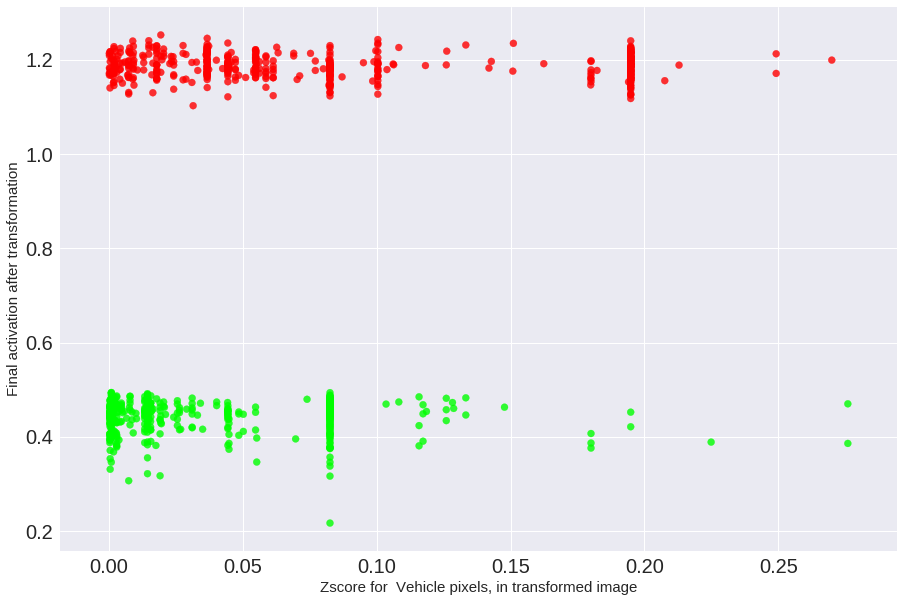

In [236]:
#beautiFied = [labelDeltas[5][i] for i in range
colorPallet=["#FF0000", "#00FF00"]

colors = [colorPallet[action[i]] for i in range(len(action)) if labelDeltas[dim][i] != 0.0 ]
delRatio = [labelDeltas[dim][i] for i in range(len(labelDeltas[dim])) if labelDeltas[dim][i] != 0.0]
delActs = [acts[i] for i in range(len(acts)) if labelDeltas[dim][i] != 0.0 ]
print len(delRatio) , len(delActs) , len(colors)
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 15)
plt.ylabel("Final activation after transformation" , fontsize = 15 )
fig = plt.scatter( delRatio , delActs,  alpha=0.8 , c = colors)
#plt.legend(['Uglified' , 'Beautified'])
plt.show()

In [237]:
len(labelDeltas[0])

1000

Extract Beauty and ugly scores for each image based on action (uglified or beautified

In [238]:
beautyDim = []


for j in range(len(labels)):
    beautyDim.append([labelDeltas[j][i] for i in range(len(action)) if (action[i]==1 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==1 ])

In [239]:
uglyDim = []

for j in range(len(labels)):
    uglyDim.append([labelDeltas[j][i] for i in range(len(action)) if(action[i]==0 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==0 ])

In [240]:
print len(beautyDim[11])

423


In [241]:
print labels

['Sky', 'Building', 'Pole', 'Road Marking', 'Road', 'Pavement', 'Tree', 'Sign Symbol', 'Fence', 'Vehicle', 'Pedestrian', 'Bike']


In [242]:
dim = 1

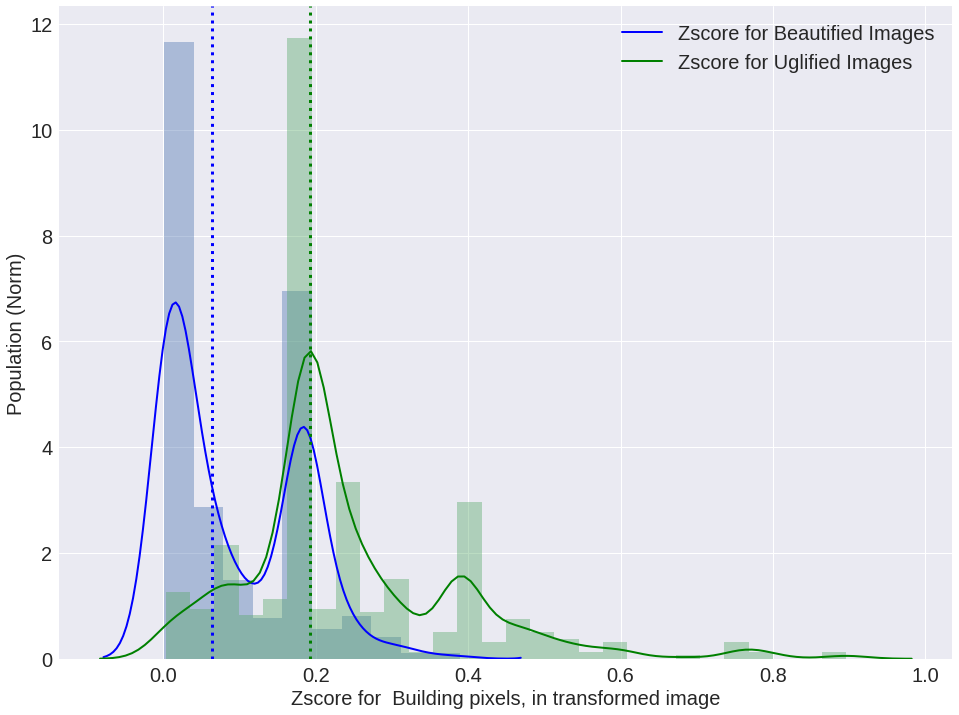

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyDim[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyDim[dim] , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [244]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['50f60c41beb2fed910000174',
   '513d7cb7fdc9f03587006faa',
   '50f561bcfdc9f065f0005640',
   '50f55eaffdc9f065f0004dfa',
   '50f5eeb0fdc9f065f0009006']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/50f60c41beb2fed910000174.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7cb7fdc9f03587006faa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f561bcfdc9f065f0005640.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f55eaffdc9f065f0004dfa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eeb0fdc9f065f0009006.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'key': '5140ca1cfdc9f0492600272f',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg'}

In [120]:
# beautifiedPlaces = []
# #beautyOrig = []
# uglifiedPlaces = []
# #uglyOrig = []c

# c1 = 0
# c2 = 0
# for k in retreivedDf:
#     if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '0':
#         #uglyOrig.append(getPlaces(retreivedDf[k]['origPath'])
#         c1+=1
# #         if c1 >= 61:
# #             continue
#         uglifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
#     else:
#         #beautyOrig.append(getPlaces(retreivedDf[k]['origPath']))
#         beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
#         c2+=1

In [277]:
# Find difference of scenes between original and transformed

beautifiedPlaces = []
uglifiedPlaces = []
for k in retreivedDf:
    if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '1':     
        uglifiedPlaces.append(getPlaces(retreivedDf[k]['origPath']))
        beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))

In [278]:
# print "Done" , str(c1) , str(c2)

In [279]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()

In [280]:
cats[1]

'/a/airport_terminal 1,,U,L\r\n'

In [281]:
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]


In [282]:
catDict

{'0': {'label': '/a/abbey', 'tnomy': 'W'},
 '1': {'label': '/a/airport_terminal', 'tnomy': 'L'},
 '10': {'label': '/a/assembly_line', 'tnomy': ''},
 '100': {'label': '/i/iceberg', 'tnomy': ''},
 '101': {'label': '/i/igloo', 'tnomy': ''},
 '102': {'label': '/i/islet', 'tnomy': ''},
 '103': {'label': '/i/ice_skating_rink/outdoor', 'tnomy': 'L'},
 '104': {'label': '/i/inn/outdoor', 'tnomy': 'A'},
 '105': {'label': '/j/jail_cell', 'tnomy': ''},
 '106': {'label': '/k/kasbah', 'tnomy': ''},
 '107': {'label': '/k/kindergarden_classroom', 'tnomy': ''},
 '108': {'label': '/k/kitchen', 'tnomy': ''},
 '109': {'label': '/k/kitchenette', 'tnomy': ''},
 '11': {'label': '/a/attic', 'tnomy': ''},
 '110': {'label': '/l/laundromat', 'tnomy': ''},
 '111': {'label': '/l/lighthouse', 'tnomy': 'L'},
 '112': {'label': '/l/living_room', 'tnomy': ''},
 '113': {'label': '/l/lobby', 'tnomy': ''},
 '114': {'label': '/l/locker_room', 'tnomy': ''},
 '115': {'label': '/m/mansion', 'tnomy': 'L'},
 '116': {'label': '/

In [283]:
def getTnomyCount(placesProbs,lblDict):
    mapper = {'W':'Walkable' , 'L' : 'Landmark' , 'A' : 'Architectural' , 'N' : 'Natural' }
    TnomyCount = {'Walkable' : 0 , 'Landmark': 0 , 'Architectural' : 0 , 'Natural' : 0}
    TnomyLabels = {'Walkable' : [] , 'Landmark': [] , 'Architectural' : [] , 'Natural' : []}
    labelList = []
    for arr in placesProbs:
        probs = np.squeeze(arr)
        topArgs = probs.argsort()[-5:][::-1]
       
        for i in topArgs:
            key = str(i)
            if lblDict[key]['tnomy'] != '':
                tnomy = lblDict[key]['tnomy']
                TnomyCount[mapper[tnomy]]+=1
                labelList.append(lblDict[key]['label'])
                TnomyLabels[mapper[tnomy]].append(lblDict[key]['label'])
    return TnomyCount , labelList , TnomyLabels

In [284]:
beautfiedTnomy, beautifiedLabels , beautyTnomyLabels = getTnomyCount(beautifiedPlaces,catDict)

In [285]:
#beauOrigTnomy , beauOrigLabels = getTnomyCount(beautyOrig,catDict)

In [286]:
#beautfiedTnomy,beauOrigTnomy

In [287]:
uglifiedTnomy, uglyfiedLabels, uglyTnomyLabels = getTnomyCount(uglifiedPlaces,catDict)

In [288]:
print beautfiedTnomy , uglifiedTnomy

{'Landmark': 205, 'Walkable': 983, 'Natural': 247, 'Architectural': 885} {'Landmark': 304, 'Walkable': 450, 'Natural': 77, 'Architectural': 1417}


In [289]:
labels = [k for k in beautfiedTnomy]

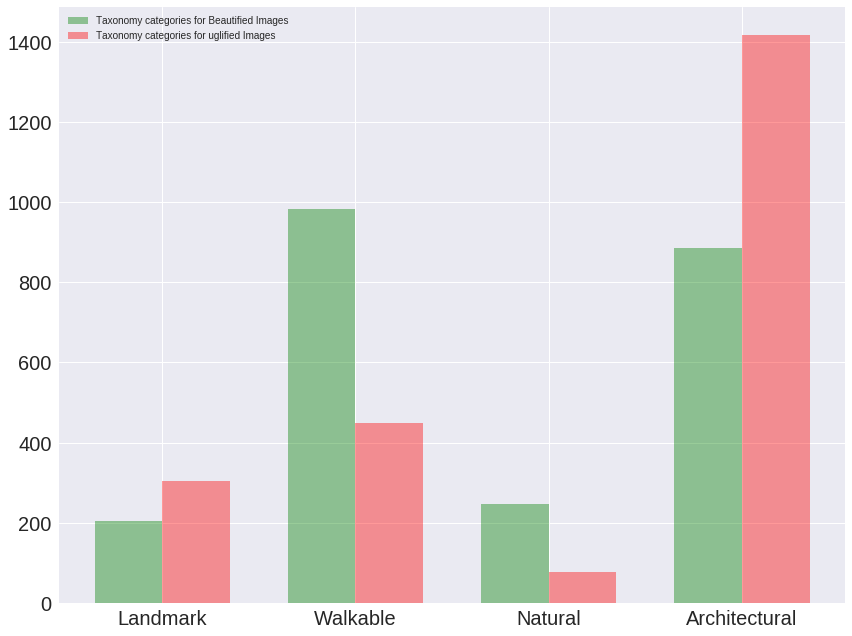

In [435]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
bar_width = 0.35
index = np.arange(4)
opacity = 0.4
sns.set(font_scale=1) 
rects1 = plt.bar(index, [beautfiedTnomy[l] for l in labels], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Taxonomy categories for Beautified Images ')
rects2 = plt.bar(index+bar_width, [uglifiedTnomy[l] for l in labels], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Taxonomy categories for uglified Images ')

#plt.xlabel('Taxonomy Category' , fontsize=20)
#plt.ylabel('Frequency of Labels in specified Category',fontsize=20)
#plt.title('Taxonomical analysis of Scene types',fontsize=20 )
plt.xticks(index + bar_width / 2, labels)
plt.legend()

plt.tight_layout()
plt.show()


In [291]:
beautyTnomyLabels.keys()

['Landmark', 'Walkable', 'Natural', 'Architectural']

In [292]:
dim = 0
beautyTnomyCount = collections.Counter(beautyTnomyLabels[labels[dim]])
uglyTnomyCount = collections.Counter(uglyTnomyLabels[labels[dim]])
prevalenceDict = {}
for k in beautyTnomyCount:
    prevalenceDict[k] = beautyTnomyCount[k] - uglyTnomyCount[k]
    
sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

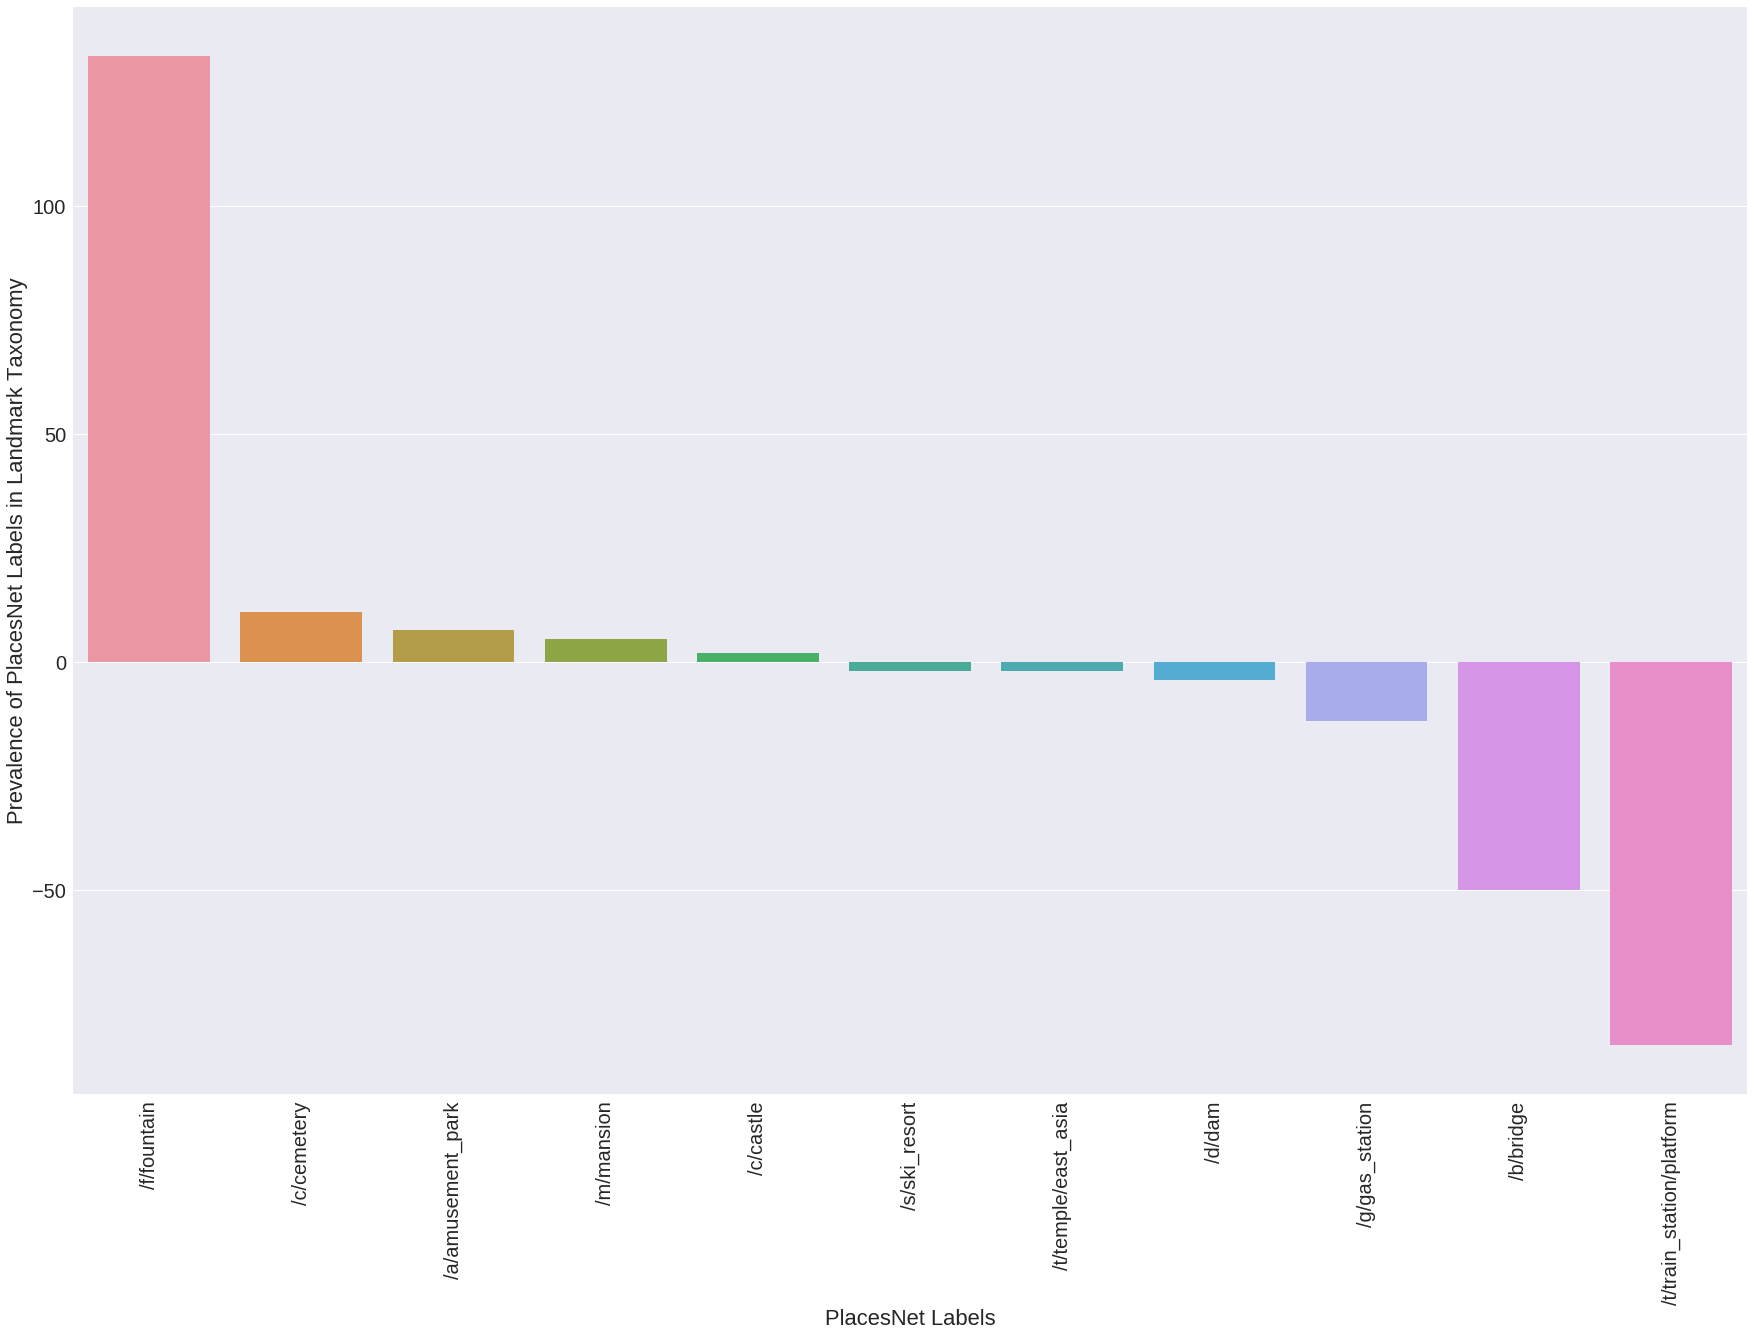

In [293]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=3) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='PlacesNet Labels', ylabel='Prevalence of PlacesNet Labels in ' + labels[dim] + ' Taxonomy') 

In [294]:
#uglyOrigTnomy , uglyOrigLabels = getTnomyCount(uglyOrig,catDict)

In [295]:
#uglifiedTnomy, uglyOrigTnomy

In [296]:
#uglyLabels

In [297]:
#beautifiedLabels

In [298]:
common = list(set(uglyfiedLabels).intersection(set(beautifiedLabels)))
#common = list(set(uglyOrigLabels).intersection(set(beauOrigLabels)))

In [299]:
beautySpecific = [i for i in beautifiedLabels if i not in common]
#beautySpecific = [i for i in beauOrigLabels if i not in common]

In [300]:
set(beautySpecific)

{'/c/cottage_garden', '/c/creek', '/p/pond'}

In [301]:
uglySpecific = [i for i in uglyfiedLabels if i not in common]

In [302]:
set(uglySpecific)

{'/a/airport_terminal',
 '/a/amphitheater',
 '/a/arch',
 '/b/bamboo_forest',
 '/b/baseball_field',
 '/b/building_facade',
 '/c/church/outdoor',
 '/c/corridor',
 '/c/courthouse',
 '/d/desert/sand',
 '/d/desert/vegetation',
 '/d/dock',
 '/d/doorway/outdoor',
 '/f/fairway',
 '/f/field/cultivated',
 '/f/field/wild',
 '/g/garbage_dump',
 '/g/golf_course',
 '/h/harbor',
 '/l/lighthouse',
 '/m/market/outdoor',
 '/m/mausoleum',
 '/m/medina',
 '/m/mountain',
 '/p/palace',
 '/p/pasture',
 '/p/pavilion',
 '/r/racecourse',
 '/r/restaurant',
 '/r/rice_paddy',
 '/r/ruin',
 '/r/runway',
 '/s/shopfront',
 '/s/ski_slope',
 '/s/sky',
 '/s/snowfield',
 '/s/stadium/baseball',
 '/s/stadium/football',
 '/s/subway_station/platform',
 '/s/supermarket',
 '/t/temple/south_asia',
 '/t/tower',
 '/v/valley',
 '/v/vegetable_garden',
 '/v/veranda',
 '/w/water_tower',
 '/w/wind_farm',
 '/w/windmill'}

In [303]:
#set(common)

In [304]:
beautyCount = collections.Counter(beautifiedLabels)
uglyCount = collections.Counter(uglyfiedLabels)
prevalenceDict = {}
for k in beautyCount:
    prevalenceDict[k] = beautyCount[k] - uglyCount[k]

In [305]:
beautyCount

Counter({'/a/alley': 32,
         '/a/amusement_park': 10,
         '/a/apartment_building/outdoor': 27,
         '/b/boardwalk': 15,
         '/b/botanical_garden': 190,
         '/b/bridge': 12,
         '/c/castle': 3,
         '/c/cemetery': 15,
         '/c/construction_site': 11,
         '/c/corn_field': 1,
         '/c/cottage_garden': 122,
         '/c/courtyard': 19,
         '/c/creek': 8,
         '/c/crosswalk': 3,
         '/d/dam': 4,
         '/d/driveway': 371,
         '/f/forest_path': 175,
         '/f/forest_road': 205,
         '/f/formal_garden': 126,
         '/f/fountain': 135,
         '/g/gas_station': 3,
         '/h/herb_garden': 3,
         '/h/highway': 58,
         '/h/hotel/outdoor': 6,
         '/i/inn/outdoor': 12,
         '/m/mansion': 9,
         '/m/motel': 10,
         '/o/office_building': 4,
         '/o/orchard': 60,
         '/p/parking_lot': 62,
         '/p/patio': 15,
         '/p/picnic_area': 2,
         '/p/playground': 5,
         '/p/

In [306]:
uglyCount

Counter({'/a/airport_terminal': 7,
         '/a/alley': 99,
         '/a/amphitheater': 3,
         '/a/amusement_park': 3,
         '/a/apartment_building/outdoor': 59,
         '/a/arch': 1,
         '/b/bamboo_forest': 1,
         '/b/baseball_field': 1,
         '/b/boardwalk': 22,
         '/b/botanical_garden': 6,
         '/b/bridge': 62,
         '/b/building_facade': 10,
         '/c/castle': 1,
         '/c/cemetery': 4,
         '/c/church/outdoor': 1,
         '/c/construction_site': 64,
         '/c/corn_field': 4,
         '/c/corridor': 2,
         '/c/courthouse': 1,
         '/c/courtyard': 28,
         '/c/crosswalk': 163,
         '/d/dam': 8,
         '/d/desert/sand': 3,
         '/d/desert/vegetation': 2,
         '/d/dock': 7,
         '/d/doorway/outdoor': 1,
         '/d/driveway': 122,
         '/f/fairway': 1,
         '/f/field/cultivated': 1,
         '/f/field/wild': 2,
         '/f/forest_path': 9,
         '/f/forest_road': 74,
         '/f/formal_garden

In [307]:

sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]


In [308]:
sortedPrevalence

[('/d/driveway', 249),
 ('/y/yard', 202),
 ('/b/botanical_garden', 184),
 ('/f/forest_path', 166),
 ('/r/river', 146),
 ('/f/fountain', 133),
 ('/f/forest_road', 131),
 ('/f/formal_garden', 125),
 ('/c/cottage_garden', 122),
 ('/o/orchard', 43),
 ('/t/tree_farm', 22),
 ('/c/cemetery', 11),
 ('/s/swamp', 11),
 ('/r/rainforest', 9),
 ('/c/creek', 8),
 ('/a/amusement_park', 7),
 ('/m/mansion', 5),
 ('/p/pond', 5),
 ('/p/patio', 5),
 ('/c/castle', 2),
 ('/i/inn/outdoor', 1),
 ('/h/hotel/outdoor', 1),
 ('/h/herb_garden', 1),
 ('/s/swimming_pool/outdoor', -1),
 ('/s/ski_resort', -2),
 ('/t/temple/east_asia', -2),
 ('/r/restaurant_patio', -2),
 ('/p/playground', -3),
 ('/c/corn_field', -3),
 ('/p/picnic_area', -3),
 ('/d/dam', -4),
 ('/b/boardwalk', -7),
 ('/c/courtyard', -9),
 ('/s/skyscraper', -12),
 ('/g/gas_station', -13),
 ('/p/plaza', -19),
 ('/a/apartment_building/outdoor', -32),
 ('/b/bridge', -50),
 ('/c/construction_site', -53),
 ('/s/slum', -61),
 ('/a/alley', -67),
 ('/o/office_bu

In [309]:
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

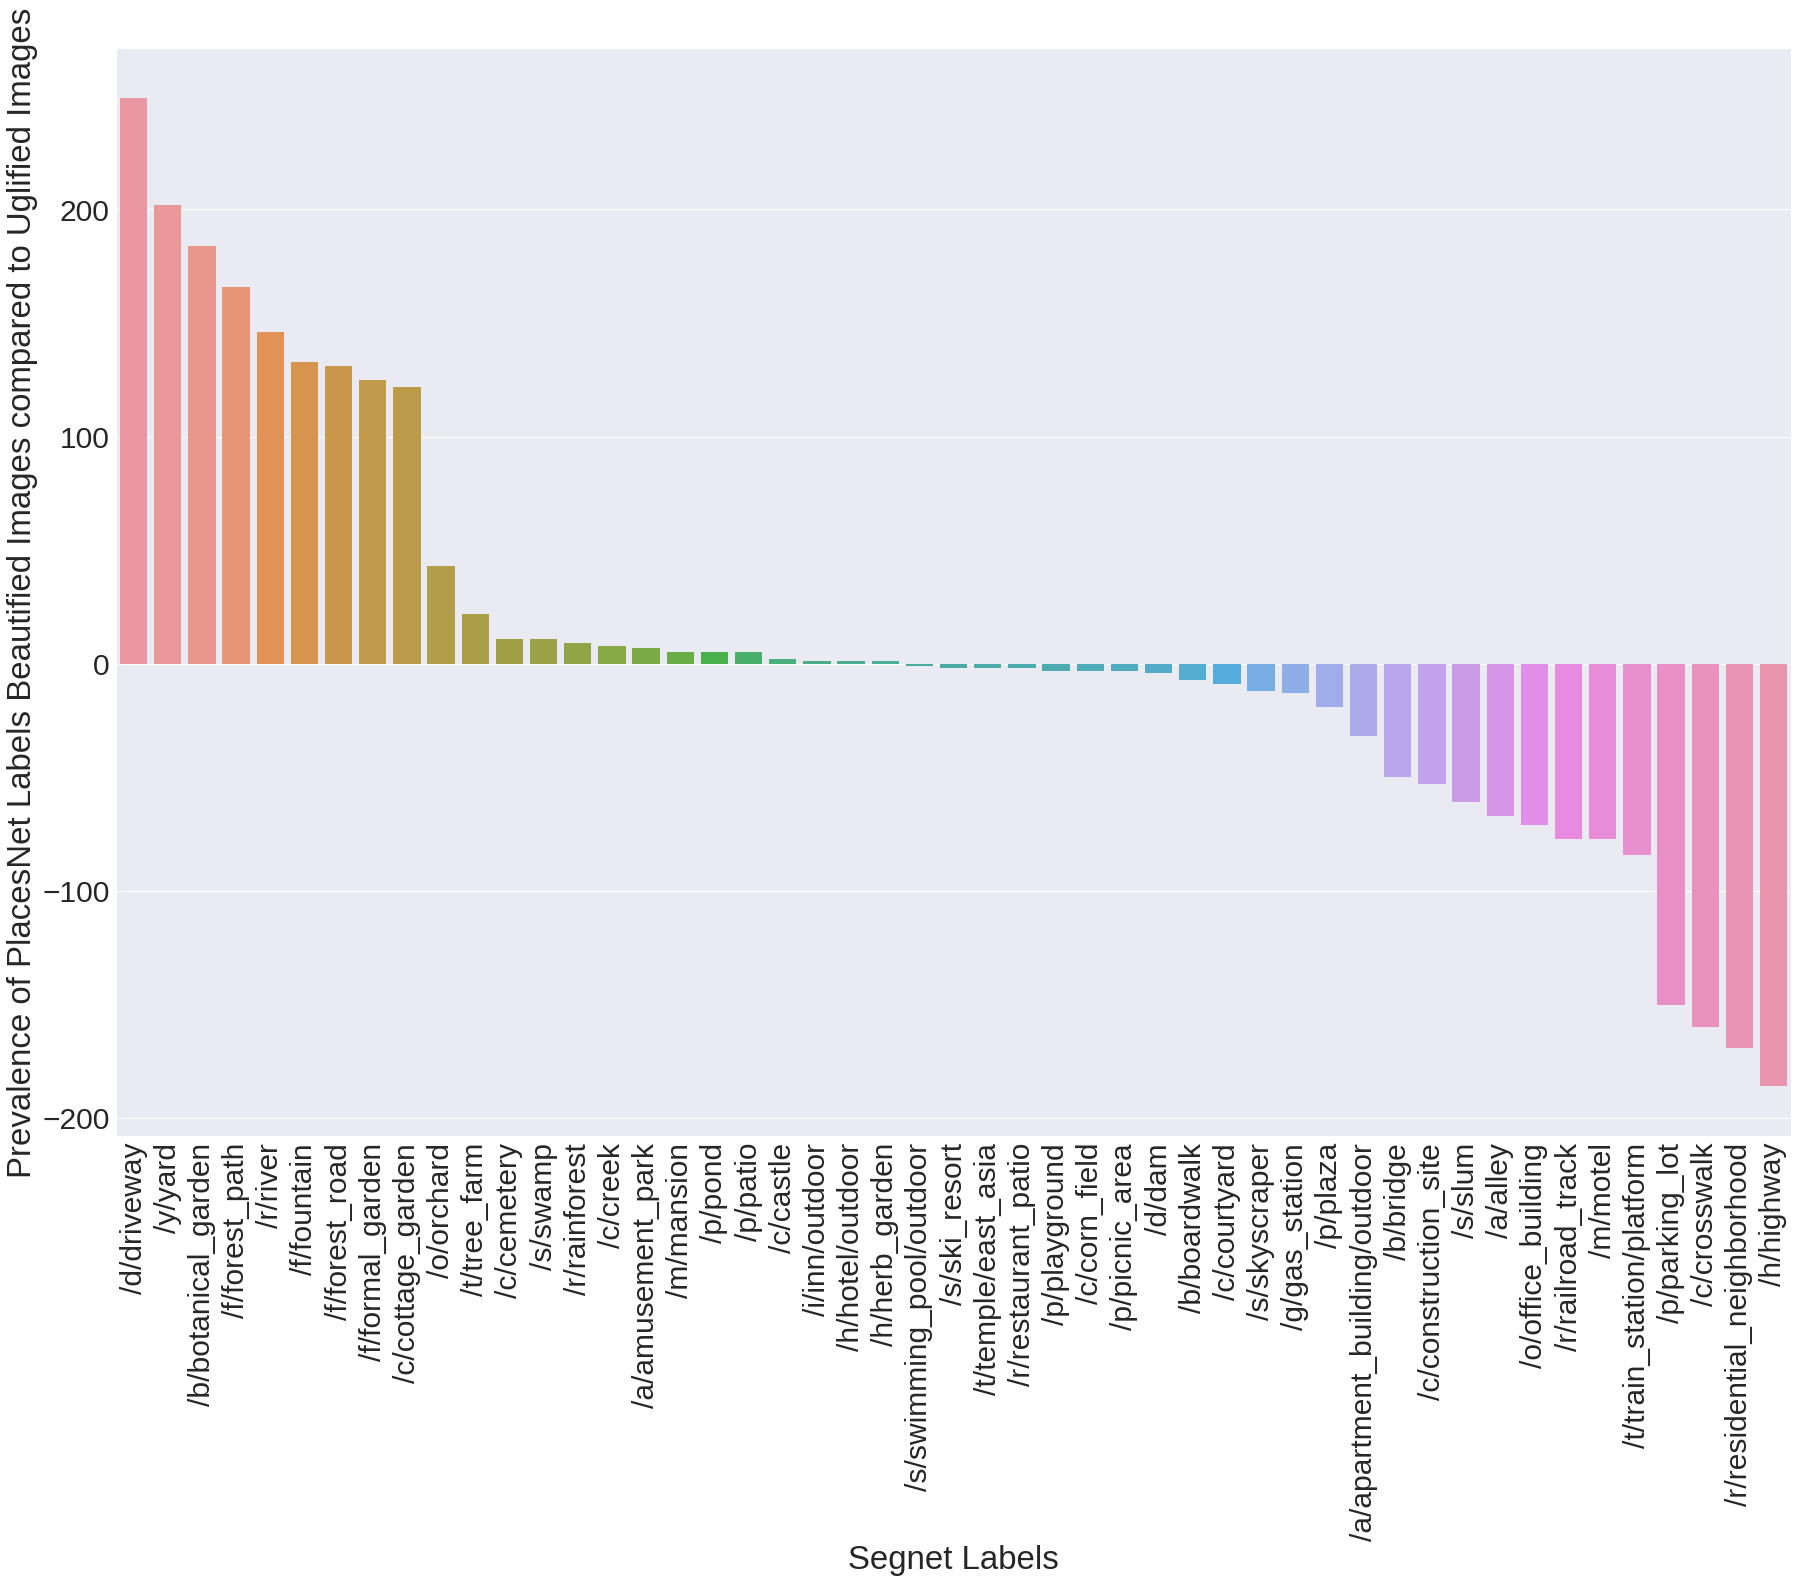

In [310]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=4) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='Segnet Labels', ylabel='Prevalence of PlacesNet Labels Beautified Images compared to Uglified Images')

## Do some texture analysis

In [311]:
# retreivedDf[retreivedDf.keys()[1]]['Top5Keys'][0]

In [423]:
textureDf = {}
textureLabels = ['Building', 'Road', 'Sky', 'Tree' ]
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    textureDf[retreivedDf[k]['key']] = {}
    textureDf[retreivedDf[k]['key']]['act'] = xformact
    textureDf[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    textureDf[retreivedDf[k]['key']]['textures'] = []
    for l in textureLabels:
        textureDf[retreivedDf[k]['key']]['textures'].append( np.median(segnetLabels[retreivedDf[k]['key']][l]))
    textureDf[retreivedDf[k]['key']]['Top5'] = {}
    matchList = retreivedDf[k]['Top5Keys'][0]
    for m in matchList:  
        if m in testSegnetLabels.keys():
            textureDf[retreivedDf[k]['key']]['Top5'][m] = []
            for l in textureLabels:
                textureDf[retreivedDf[k]['key']]['Top5'][m].append(np.median(testSegnetLabels[m][l]))


    

In [424]:
textureDf[textureDf.keys()[1]]

{'Top5': {'50f55eaffdc9f065f0004dfa': [17.185032139577597,
   3.7164374999999996,
   0.50178536004760954,
   16.15463137996219],
  '50f561bcfdc9f065f0005640': [0.0,
   13.971944444444446,
   0.91982699252491185,
   22.23363285498732],
  '50f5eeb0fdc9f065f0009006': [4.6142755428978273,
   2.1114392923996759,
   1.2858606557377052,
   37.867966760088912],
  '50f60c41beb2fed910000174': [0.0,
   10.141787190082642,
   15.76430047225502,
   11.301162637072263],
  '513d7cb7fdc9f03587006faa': [19.530191924134598,
   5.7606525444363283,
   2.4755102040816328,
   26.527169811320761]},
 'act': 0.462293,
 'label': 1,
 'textures': [43.735733333333336,
  4.123828406633022,
  1.7879243221091454,
  10.004305555555554]}

In [425]:
scores = {}
for k in testSegnetLabels:
    for l in textureLabels:
        if l not in scores:
            scores[l] = []
        scores[l].append(np.median(testSegnetLabels[m][l]))

In [426]:
meanTextures = {}
stdTextures = {}
for k in scores:
    meanTextures[k] = np.mean(scores[k])
    stdTextures[k] = np.std(scores[k])
    
print meanTextures , stdTextures

{'Building': 1.8013409961685822, 'Sky': 0.42178142545085084, 'Tree': 2.1328125000000004, 'Road': 4.3904029016763078} {'Building': 2.2204460492503131e-16, 'Sky': 1.1102230246251565e-16, 'Tree': 4.4408920985006262e-16, 'Road': 8.8817841970012523e-16}


In [512]:
dim = 3

In [513]:
testSegnetLabels[testSegnetLabels.keys()[1]][textureLabels[dim]]

array([[ 0.,  0.,  0.,  0.]])

In [514]:
beautyTextureZscore = []
uglyTextureZscore = []
for k in textureDf:
    aggregate = [ np.median(testSegnetLabels[m][textureLabels[dim]][0]) for m in textureDf[k]['Top5'] ]
    for a in aggregate:
        orig = a
        Zscore = (orig - meanTextures[textureLabels[dim]])/stdTextures[textureLabels[dim]]
        if textureDf[k]['label'] == 1:
            beautyTextureZscore.append(Zscore)
        else:
            uglyTextureZscore.append(Zscore)
print aggregate

[2.1328125000000009, 14.335042735042723, 12.229476196911307, 0.0, 19.117222222222217]


In [515]:
len(beautyTextureZscore)

2515

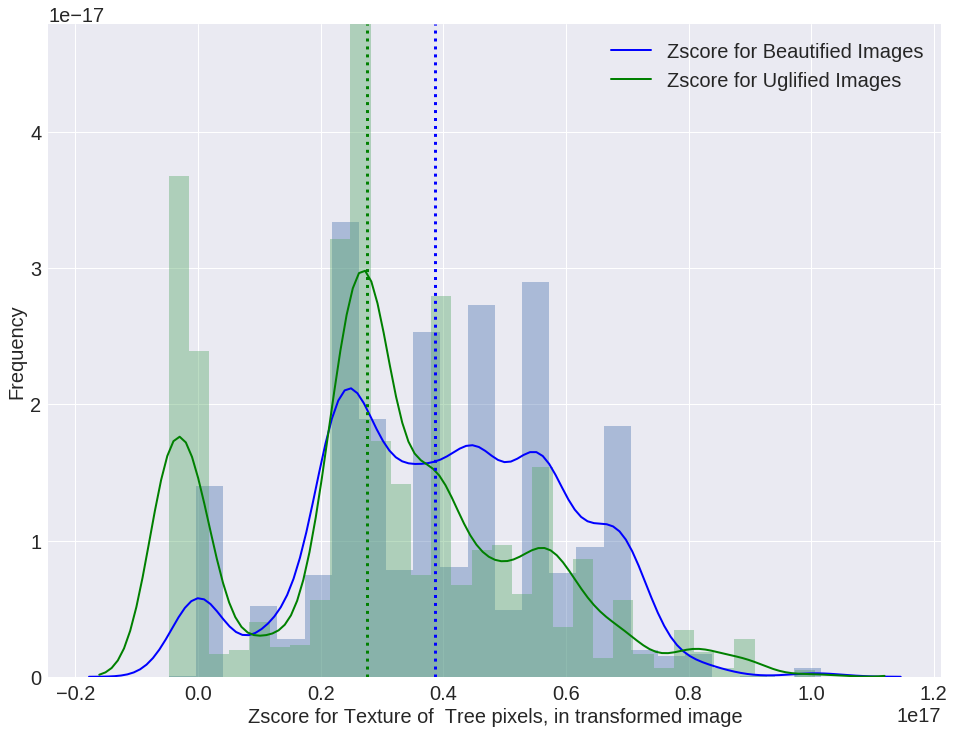

In [516]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyTextureZscore ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyTextureZscore , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyTextureZscore), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyTextureZscore), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for Texture of  " + textureLabels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )